In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
from cmocean import cm
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='04:00:00')
w = cluster.scale(1*12)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.152:33554 Dashboard: /user/yux/proxy/8787/status,Cluster Workers: 12 Cores: 12 Memory: 200.04 GB


___________
# Useful info.

In [5]:
dij=4 
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
depth = grd_rspec.Depth.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

# coriolis term
lat = grd_rspec['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))

In [6]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

_________________

## Part 1. global KE comparisons (among ageostrophic, geostrophic and total uv)

(lat,lon,KE)

In [7]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr('/work/ALT/swot/aval/syn/xy/KE/KE_total_f%02d.zarr'%(face)) for face in face_all] 
ds_KE = xr.concat(D, dim='face')

D = [xr.open_zarr('/work/ALT/swot/aval/syn/xy/KE/KEg_total_f%02d.zarr'%(face)) for face in face_all] 
ds_KEg = xr.concat(D, dim='face')

D = [xr.open_zarr('/work/ALT/swot/aval/syn/xy/KE/KEa_total_f%02d.zarr'%(face)) for face in face_all] 
ds_KEa = xr.concat(D, dim='face')

ds = xr.merge([ds_KE,ds_KEg,ds_KEa])
ds

<xarray.Dataset>
Dimensions:       (face: 13, i: 1080, j: 1080)
Coordinates:
    CS            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * i             (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j             (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask          (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    KE_eddy       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KE_meanflow   (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KE_total      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEg_eddy      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEg_meanflow  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEg_total     (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEa_eddy      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEa_meanflow  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEa_total     (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [8]:
# KE from spectra with no detrending and no windowing
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/total_uv_all/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_total_all = xr.concat(D, dim='face')
E_total_all = ds_total_all.E_all
E_total_all_low = ds_total_all.E_low

D = [xr.open_zarr(work_data_dir+'xy/geo_uv_all/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_geo_all = xr.concat(D, dim='face')
E_geo_all = ds_geo_all.E_all
E_geo_low_all = ds_geo_all.E_low

D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv_all/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_ageo_all = xr.concat(D, dim='face')
E_ageo_all = ds_ageo_all.E_all
E_ageo_all_low = ds_ageo_all.E_low
E_ageo_all_high = ds_ageo_all.E_high

In [9]:
# KE from spectra with windowing but no detrending 
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/total_uv_window/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_total_window = xr.concat(D, dim='face')
E_total_window = ds_total_window.E_all
E_total_window_low = ds_total_window.E_low

D = [xr.open_zarr(work_data_dir+'xy/geo_uv_window/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_geo_window = xr.concat(D, dim='face')
E_geo_window = ds_geo_window.E_all

D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv_window/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_ageo_window = xr.concat(D, dim='face')
E_ageo_window = ds_ageo_window.E_all
E_ageo_low_window = ds_ageo_window.E_low
E_ageo_high_window = ds_ageo_window.E_high

In [10]:
# KE from spectra with detrending  but no windowing
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/total_uv_detrend/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_total_detrend = xr.concat(D, dim='face')
E_total_detrend = ds_total_detrend.E_all
E_total_detrend_low = ds_total_detrend.E_low

D = [xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_geo_detrend = xr.concat(D, dim='face')
E_geo_detrend = ds_geo_detrend.E_all

D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_ageo_detrend = xr.concat(D, dim='face')
E_ageo_detrend = ds_ageo_detrend.E_all
E_ageo_low_detrend = ds_ageo_detrend.E_low
E_ageo_high_detrend = ds_ageo_detrend.E_high

In [11]:
# KE from spectra with both detrending and windowing
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/total_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_total = xr.concat(D, dim='face')
E_total = ds_total.E_all
E_total_low = ds_total.E_low

D = [xr.open_zarr(work_data_dir+'xy/geo_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_geo = xr.concat(D, dim='face')
E_geo = ds_geo.E_all

D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_ageo = xr.concat(D, dim='face')
E_ageo = ds_ageo.E_all
E_ageo_low = ds_ageo.E_low
E_ageo_high = ds_ageo.E_high

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

(<cartopy.mpl.feature_artist.FeatureArtist at 0x2b0fc1af4b20>,
 <cartopy.mpl.feature_artist.FeatureArtist at 0x2b0fc259b130>)

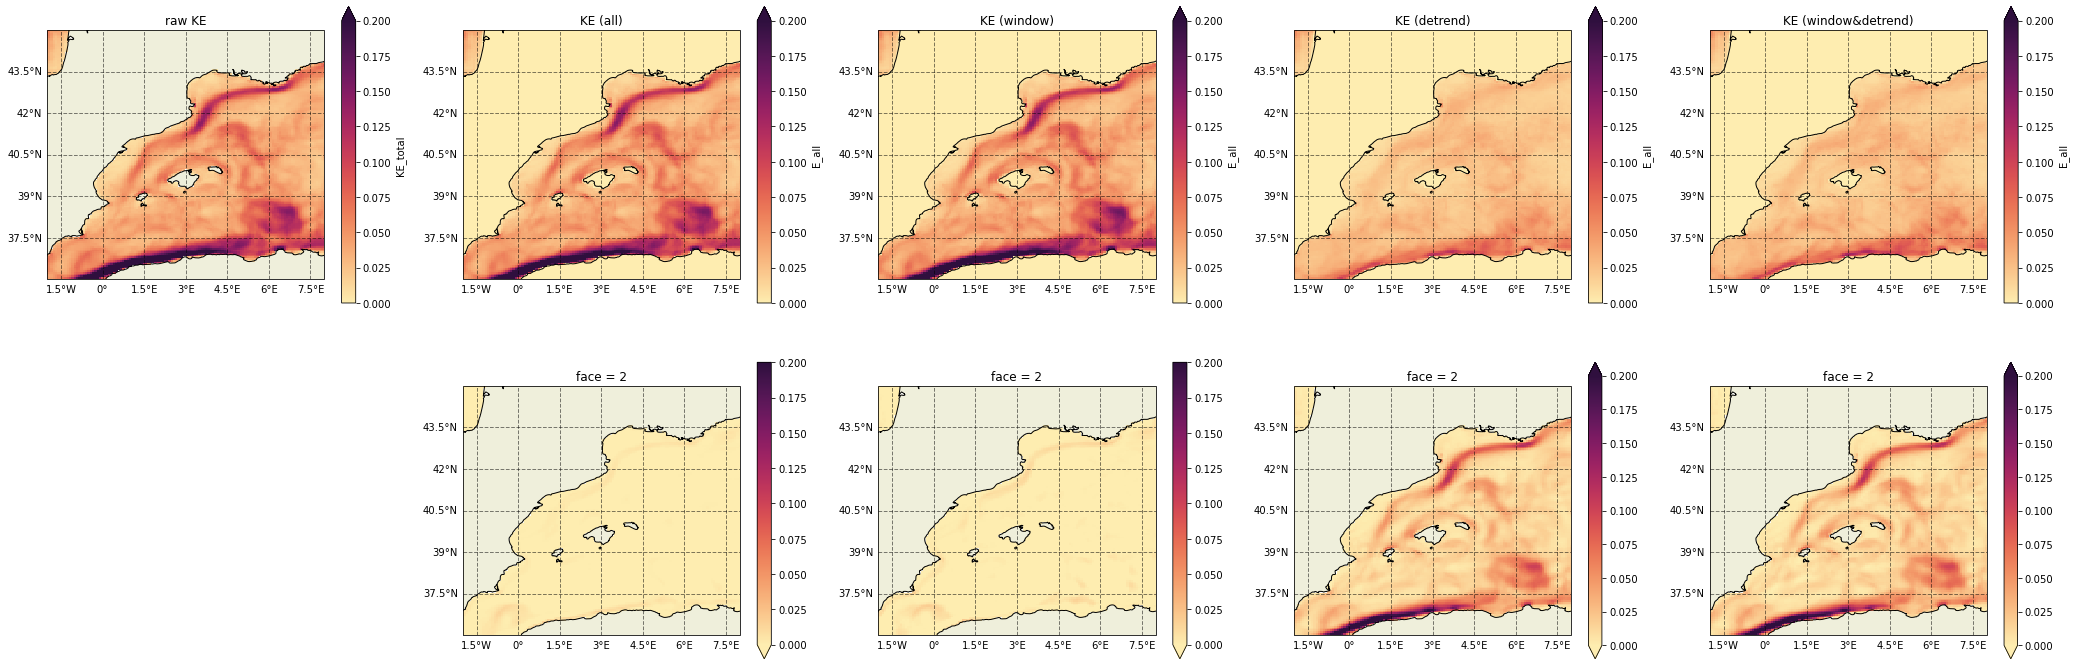

In [32]:
# Total
vmin = 0
vmax = 0.2
depth = 500

fig = plt.figure(figsize=(36,12))

# KE
ax = fig.add_subplot(251, projection=ccrs.PlateCarree())
(2*ds.KE_total.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('raw KE')

ax = fig.add_subplot(252, projection=ccrs.PlateCarree())
E_total_all.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (all)')

ax = fig.add_subplot(253, projection=ccrs.PlateCarree())
E_total_window.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (window)')

ax = fig.add_subplot(254, projection=ccrs.PlateCarree())
E_total_detrend.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (detrend)')

ax = fig.add_subplot(255, projection=ccrs.PlateCarree())
E_total.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)      
ax.set_title('KE (window&detrend)')




ax = fig.add_subplot(257, projection=ccrs.PlateCarree())
(2*ds.KE_total.isel(face=2)-E_total_all.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')


ax = fig.add_subplot(258, projection=ccrs.PlateCarree())
(2*ds.KE_total.isel(face=2)-E_total_window.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(259, projection=ccrs.PlateCarree())
(2*ds.KE_total.isel(face=2)-E_total_detrend.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(2,5,10, projection=ccrs.PlateCarree())
(2*ds.KE_total.isel(face=2)-E_total.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

(<cartopy.mpl.feature_artist.FeatureArtist at 0x2b0fba3795e0>,
 <cartopy.mpl.feature_artist.FeatureArtist at 0x2b0fca379be0>)

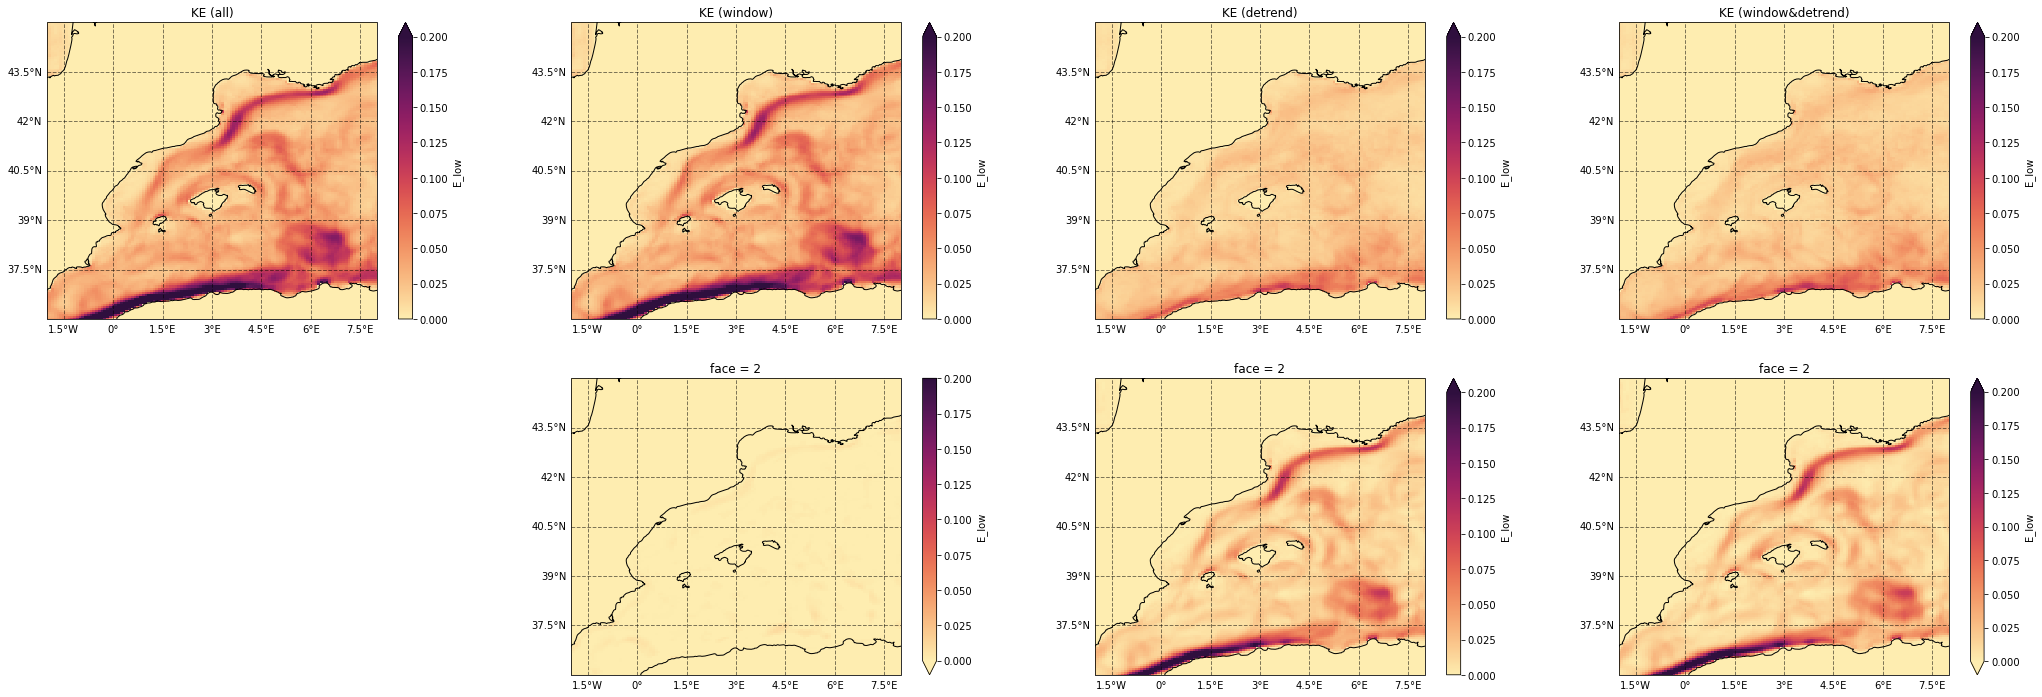

In [35]:
# Total (low)
vmin = 0
vmax = 0.2
depth = 500

fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot(241, projection=ccrs.PlateCarree())
E_total_all_low.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (all)')

ax = fig.add_subplot(242, projection=ccrs.PlateCarree())
E_total_window_low.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (window)')

ax = fig.add_subplot(243, projection=ccrs.PlateCarree())
E_total_detrend_low.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (detrend)')

ax = fig.add_subplot(244, projection=ccrs.PlateCarree())
E_total_low.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)      
ax.set_title('KE (window&detrend)')


ax = fig.add_subplot(246, projection=ccrs.PlateCarree())
(E_total_all_low.isel(face=2)-E_total_window_low.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(247, projection=ccrs.PlateCarree())
(E_total_all_low.isel(face=2)-E_total_detrend_low.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(248, projection=ccrs.PlateCarree())
(E_total_all_low.isel(face=2)-E_total_low.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

(<cartopy.mpl.feature_artist.FeatureArtist at 0x2b0fcadfb4f0>,
 <cartopy.mpl.feature_artist.FeatureArtist at 0x2b0fcaf6cb80>)

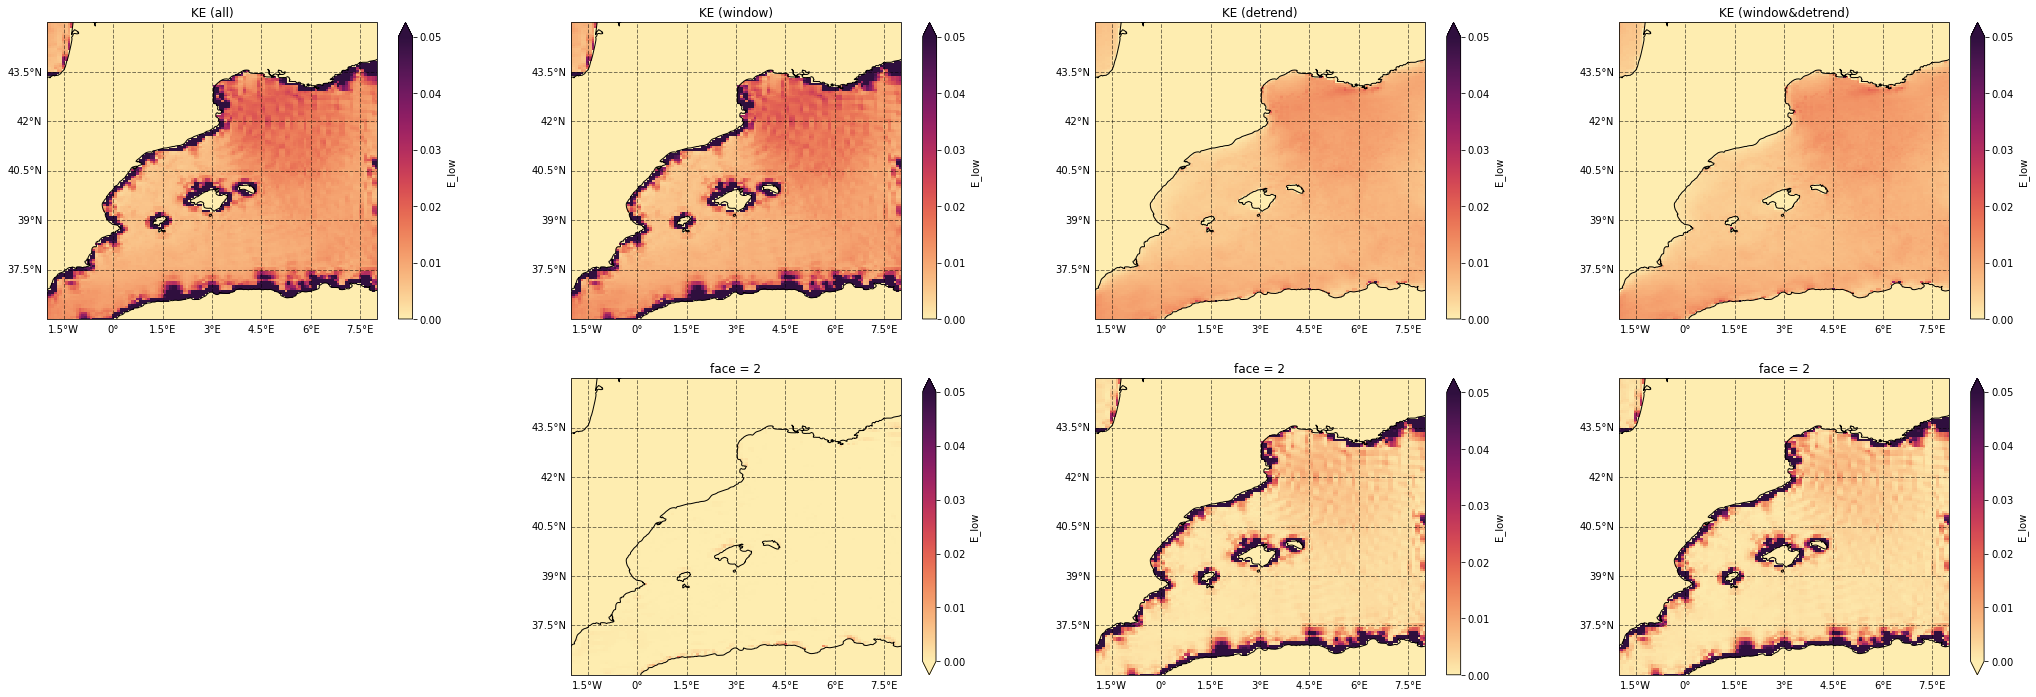

In [38]:
# Ageo (low)
vmin = 0
vmax = 0.05
depth = 500

fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot(241, projection=ccrs.PlateCarree())
E_ageo_all_low.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (all)')

ax = fig.add_subplot(242, projection=ccrs.PlateCarree())
E_ageo_low_window.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (window)')

ax = fig.add_subplot(243, projection=ccrs.PlateCarree())
E_ageo_low_detrend.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
ax.set_title('KE (detrend)')

ax = fig.add_subplot(244, projection=ccrs.PlateCarree())
E_ageo_low.isel(face=2).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)      
ax.set_title('KE (window&detrend)')


ax = fig.add_subplot(246, projection=ccrs.PlateCarree())
(E_ageo_all_low.isel(face=2)-E_ageo_low_window.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(247, projection=ccrs.PlateCarree())
(E_ageo_all_low.isel(face=2)-E_ageo_low_detrend.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(248, projection=ccrs.PlateCarree())
(E_ageo_all_low.isel(face=2)-E_ageo_low.isel(face=2)).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.); ax.set_ylim(36., 45.); gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False; gl.right_labels = False; ax.coastlines(resolution='10m', color='k'), ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

______________
# Ratio

In [10]:
import matplotlib.colors as colors

bounds = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
print(norm)

In [11]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='110m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap=plt.cm.get_cmap('RdBu_r', 11)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
#        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],extend='max')
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2],extend='max')

        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
        ax.set_ylim(-60., 60.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [31]:
# Figure 6a (KEa/KE)
plot_pretty( (E_ageo_all/E_total_all)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (E_ageo_all.j!=40) & (np.abs(E_ageo_all.YC)>10) ), 
              label='', vmin=0, vmax=2, cmmap='RdBu_r', ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_06_21.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [32]:
# Figure  (KEg/KE)
plot_pretty( (E_geo_all/E_total_all)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (E_ageo_all.j!=40) & (np.abs(E_ageo_all.YC)>10) ), 
              label='', vmin=0, vmax=2, cmmap='RdBu_r', ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_06_22.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [33]:
# Figure  (KEg/KE)
plot_pretty( ( (E_ageo_all + E_geo_all)/E_total_all)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (E_ageo_all.j!=40) & (np.abs(E_ageo_all.YC)>10) ), 
              label='', vmin=0, vmax=2, cmmap='RdBu_r', ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_06_23.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

# the role of high frequencies

In [12]:
a = (E_ageo_all/E_total_all).isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (depth>500) & (E_ageo_all.j!=40) & (np.abs(E_ageo_all.YC)>10) )
a

<xarray.DataArray 'E_all' (face: 13, j: 1078, i: 1078)>
dask.array<where, shape=(13, 1078, 1078), dtype=float64, chunksize=(1, 1078, 1078), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 4 8 12 16 20 24 28 ... 4288 4292 4296 4300 4304 4308 4312
  * i        (i) int64 4 8 12 16 20 24 28 ... 4288 4292 4296 4300 4304 4308 4312
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XC       (face, j, i) float32 -114.4 -114.4 -114.4 ... -112.9 -113.5 -114.0
    YC       (face, j, i) float32 -88.19 -88.2 -88.21 ... -88.15 -88.15 -88.15
    dxC      (face, j, i) float32 324.6 324.7 324.7 324.7 ... 481.7 480.9 480.1
    dxG      (face, j, i) float32 324.6 324.7 324.7 324.7 ... 481.6 480.8 480.0
    dyC      (face, j, i) float32 479.7 479.8 479.9 480.0 ... 324.6 324.6 324.6
    dyG      (face, j, i) float32 479.8 479.9 480.0 480.1 ... 324.6 324.6 324.6
    f_i      (face, j, i) float32 -0.0001458 -0.0001458 ... -0.0001458
    f_j      (face, j, i) float32 -0.0001458 -0.0001458 ... -0.0001458
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    mask     (face, j, i) bool False False False False ... False False False

In [13]:
b = ((E_total_all - E_total_all_low)/E_total_all).isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (depth>500) & (E_ageo_all.j!=40) & (np.abs(E_ageo_all.YC)>10) )
b

<xarray.DataArray (face: 13, j: 1078, i: 1078)>
dask.array<where, shape=(13, 1078, 1078), dtype=float64, chunksize=(1, 1078, 1078), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 4 8 12 16 20 24 28 ... 4288 4292 4296 4300 4304 4308 4312
  * i        (i) int64 4 8 12 16 20 24 28 ... 4288 4292 4296 4300 4304 4308 4312
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XC       (face, j, i) float32 -114.4 -114.4 -114.4 ... -112.9 -113.5 -114.0
    YC       (face, j, i) float32 -88.19 -88.2 -88.21 ... -88.15 -88.15 -88.15
    dxC      (face, j, i) float32 324.6 324.7 324.7 324.7 ... 481.7 480.9 480.1
    dxG      (face, j, i) float32 324.6 324.7 324.7 324.7 ... 481.6 480.8 480.0
    dyC      (face, j, i) float32 479.7 479.8 479.9 480.0 ... 324.6 324.6 324.6
    dyG      (face, j, i) float32 479.8 479.9 480.0 480.1 ... 324.6 324.6 324.6
    f_i      (face, j, i) float32 -0.0001458 -0.0001458 ... -0.0001458
    f_j      (face, j, i) float32 -0.0001458 -0.0001458 ... -0.0001458
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    mask     (face, j, i) bool False False False False ... False False False

In [14]:
a = np.real(a).rename('a')    
b = np.real(b).rename('b')    
ds = xr.merge([a,b])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 1078, j: 1078)
Coordinates:
  * j        (j) int64 4 8 12 16 20 24 28 ... 4288 4292 4296 4300 4304 4308 4312
  * i        (i) int64 4 8 12 16 20 24 28 ... 4288 4292 4296 4300 4304 4308 4312
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XC       (face, j, i) float32 -114.4 -114.4 -114.4 ... -112.9 -113.5 -114.0
    YC       (face, j, i) float32 -88.19 -88.2 -88.21 ... -88.15 -88.15 -88.15
    dxC      (face, j, i) float32 324.6 324.7 324.7 324.7 ... 481.7 480.9 480.1
    dxG      (face, j, i) float32 324.6 324.7 324.7 324.7 ... 481.6 480.8 480.0
    dyC      (face, j, i) float32 479.7 479.8 479.9 480.0 ... 324.6 324.6 324.6
    dyG      (face, j, i) float32 479.8 479.9 480.0 480.1 ... 324.6 324.6 324.6
    f_i      (face, j, i) float32 -0.0001458 -0.0001458 ... -0.0001458
    f_j      (face, j, i) float32 -0.0001458 -0.0001458 ... -0.0001458
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    mask     (face, j, i) bool False False False False ... False False False
Data variables:
    a        (face, j, i) float64 dask.array<chunksize=(1, 1078, 1078), meta=np.ndarray>
    b        (face, j, i) float64 dask.array<chunksize=(1, 1078, 1078), meta=np.ndarray>

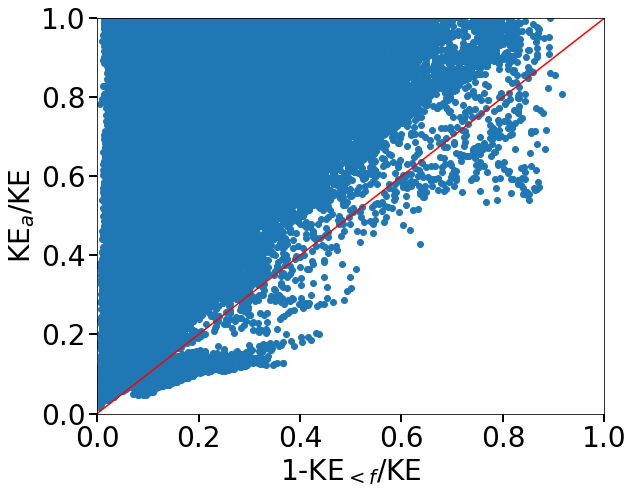

In [38]:
font_size = 28

fig = plt.figure(figsize=(16,16))

plt.subplot(111)
ds.plot.scatter(y='a', x='b')
plt.axis([0,1, 0,1])
plt.xlabel("1-KE$_{<f}$/KE",fontsize=font_size)
plt.ylabel("KE$_a$/KE",fontsize=font_size)

plt.plot( [0,1],[0,1] ,'r-')
plt.tick_params(labelsize=font_size)

plt.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_06_31.png',dpi=180)

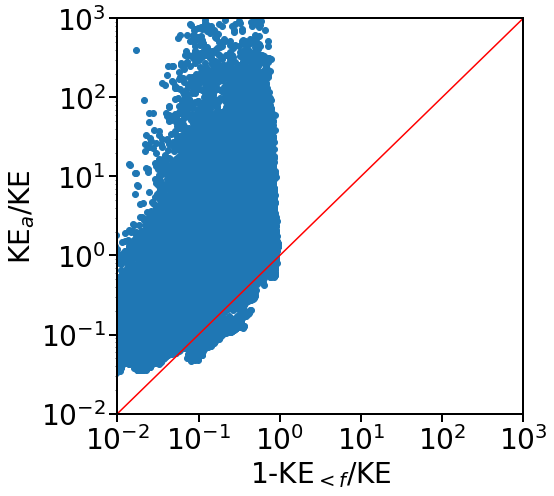

In [39]:
fig = plt.figure(figsize=(16,16))

plt.subplot(111)
ax = plt.gca()
ds.plot.scatter(y='a', x='b')

ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(0.01,1000);
plt.ylim(0.01,1000);
ax.set_xticks([0.01,0.1,1,10,100,1000])
ax.set_yticks([0.01,0.1,1,10,100,1000])
plt.xlabel("1-KE$_{<f}$/KE",fontsize=font_size)
plt.ylabel("KE$_a$/KE",fontsize=font_size)
plt.plot( [0,1000],[0,1000] ,'r-')
plt.tick_params(labelsize=font_size)
plt.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_06_32.png',dpi=180)

In [16]:
font_size = 24

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[-2, -1, 0, 1])
        cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$','10$^1$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_xlim(-128., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [22]:
# KE
plot_pretty( np.log10(  E_total_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KE_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [18]:
# KEg
plot_pretty( np.log10(  E_geo_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEg_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [19]:
# KEa
plot_pretty( np.log10(  E_ageo_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEa_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [11]:
font_size = 24

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[-2, -1, 0, 1])
        cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$','10$^1$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_xlim(-130., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-130, -128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$130\degree$W','$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [15]:
# KE
plot_pretty( np.log10(  E_total_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KE.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [16]:
# KEg
plot_pretty( np.log10(  E_geo_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEg.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [17]:
# KEa
plot_pretty( np.log10(  E_ageo_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEa.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [18]:
font_size = 24

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[-2, -1, 0, 1])
        cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$','10$^1$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_xlim(-2., 8.)
        ax.set_ylim(36., 45.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-2, 0, 2, 4, 6, 8])
        ax.set_xticklabels(['$2\degree$W','$0\degree$','$2\degree$E','$4\degree$E','$6\degree$E','$8\degree$E'])
        ax.set_yticks([36,39,42,45])
        ax.set_yticklabels(['$36\degree$N','$39\degree$N','$42\degree$N','$45\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [20]:
# KE
plot_pretty( np.log10(  E_total_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_KE.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [21]:
# KEg
plot_pretty( np.log10(  E_geo_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_KEg.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [22]:
# KEa
plot_pretty( np.log10(  E_ageo_all.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', 
             figsize=(12,16), ignore_face=[6],
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_KEa.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

______________
# Ratio

In [24]:
import matplotlib.colors as colors

bounds = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=5)
print(norm)

In [25]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap=plt.cm.get_cmap('RdBu_r', 6)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],extend='max')
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-128., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [26]:
# Figure 6a (KEa/KE)
plot_pretty( (E_ageo_all_low/E_total_all_low)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (np.abs(E_ageo_all.YC)>10) ), 
              label='', vmin=0, vmax=1, cmmap='RdBu_r', 
              figsize=(12,16), ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEa_low_KE_low_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [24]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap=plt.cm.get_cmap('RdBu_r', 6)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],extend='max')
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-130., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-130, -128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$130\degree$W','$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [26]:
# Figure 6a (KEa/KE)
plot_pretty( (E_ageo_all_low/E_total_all_low)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (np.abs(E_ageo_all.YC)>10) ), 
              label='', vmin=0, vmax=1, cmmap='RdBu_r', 
              figsize=(12,16), ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEa_low_KE_low.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [27]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap=plt.cm.get_cmap('RdBu_r', 6)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],extend='max')
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-2., 8.)
        ax.set_ylim(36., 45.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-2, 0, 2, 4, 6, 8])
        ax.set_xticklabels(['$2\degree$W','$0\degree$','$2\degree$E','$4\degree$E','$6\degree$E','$8\degree$E'])
        ax.set_yticks([36,39,42,45])
        ax.set_yticklabels(['$36\degree$N','$39\degree$N','$42\degree$N','$45\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [28]:
# Figure 6a (KEa/KE)
plot_pretty( (E_ageo_all_low/E_total_all_low)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (E_ageo_all.j!=40) & (np.abs(E_ageo_all.YC)>10) ), 
              label='', vmin=0, vmax=1, cmmap='RdBu_r',
              figsize=(12,16), ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_KEa_low_KE_low.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

# Subinertial band

In [27]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/revision/E_geo_omega_f_f%02d.zarr'%(face)) for face in face_all] 
ds_all = xr.concat(D, dim='face')
print(ds_all)

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxC              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxG              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyC              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face             (face) int64 0 1 2 3 4 5 6

In [28]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/revision/E_omega_f_f%02d.zarr'%(face)) for face in face_all] 
ds_total = xr.concat(D, dim='face')
print(ds_total)
E_total = ds_total.E_all 

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxC              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxG              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyC              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j              (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face             (face) int64 0 1 2 3 4 5 6

In [29]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['r', 'g', 'b', 'k','y'])
norm = BoundaryNorm([0, 0.2, 0.4, 0.6, 0.8, 1], cmap.N)

In [30]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        #cmap=plt.cm.get_cmap('RdBu_r', 6)
        cmap = ListedColormap(['#053061', '#4393c3', '#d1e5f0', '#fddbc7','#d6604d'])

        #cmap = ListedColormap(['#053061', '#4393c3', '#d1e5f0', '#fddbc7'])

        norm = BoundaryNorm([0, 0.2, 0.4, 0.6, 0.8, 1], cmap.N)
        cmap.set_over("darkred")
        #cmap.set_under("blue")
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], extend='max')
        #cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-128., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [31]:
# Figure 6a (KEa/KE)
plot_pretty( ( abs(E_total - ds_all.E_subinertial) /E_total)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (np.abs(ds_all.YC)>10) ), 
              label='', vmin=0, vmax=1, cmmap='RdBu_r',
              figsize=(12,16), ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEa_sub_KE_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [32]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        #cmap=plt.cm.get_cmap('RdBu_r', 6)
        cmap = ListedColormap(['#053061', '#4393c3', '#d1e5f0', '#fddbc7','#d6604d'])

        #cmap = ListedColormap(['#053061', '#4393c3', '#d1e5f0', '#fddbc7'])

        norm = BoundaryNorm([0, 0.2, 0.4, 0.6, 0.8, 1], cmap.N)
        cmap.set_over("darkred")
        #cmap.set_under("blue")
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], extend='max')
        #cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-130., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-130, -128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$130\degree$W','$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [33]:
# Figure 6a (KEa/KE)
plot_pretty( ( abs(E_total - ds_all.E_subinertial) /E_total)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (np.abs(ds_all.YC)>10) ), 
              label='', vmin=0, vmax=1, cmmap='RdBu_r',
              figsize=(12,16), ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_KEa_sub_KE.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [34]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        #cmap=plt.cm.get_cmap('RdBu_r', 6)
        cmap = ListedColormap(['#053061', '#4393c3', '#d1e5f0', '#fddbc7','#d6604d'])

        #cmap = ListedColormap(['#053061', '#4393c3', '#d1e5f0', '#fddbc7'])

        norm = BoundaryNorm([0, 0.2, 0.4, 0.6, 0.8, 1], cmap.N)
        cmap.set_over("darkred")
        #cmap.set_under("blue")
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap, norm=norm)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], extend='max')
        #cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-2., 8.)
        ax.set_ylim(36., 45.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-2, 0, 2, 4, 6, 8])
        ax.set_xticklabels(['$2\degree$W','$0\degree$','$2\degree$E','$4\degree$E','$6\degree$E','$8\degree$E'])
        ax.set_yticks([36,39,42,45])
        ax.set_yticklabels(['$36\degree$N','$39\degree$N','$42\degree$N','$45\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [35]:
# Figure 6a (KEa/KE)
plot_pretty( ( abs(E_total - ds_all.E_subinertial) /E_total)
              .isel(i=slice(1,-1),j=slice(1,-1))
              .where( (ice>0) & (depth>500) & (np.abs(ds_all.YC)>10) ), 
              label='', vmin=0, vmax=1, cmmap='RdBu_r',
              figsize=(12,16), ignore_face=[6],
              savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_KEa_sub_KE.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

# Snapshot

# Read short-period data

In [32]:
ds = xr.open_zarr(work_data_dir+'xy/comparison/snapshot/uveta_snapshot.zarr')

#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])

# coriolis term
lat = grd_rspec['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))

ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
ice = ds_ice.AREA

In [33]:
import xgcm
# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
gridx = xgcm.Grid(ds, periodic=False, face_connections=face_connections)
gridx

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [34]:
# u
u = ds.SSU.sel(time='2011-11-24T08:00:00').rename({'i_g': 'i'})
v = ds.SSV.sel(time='2011-11-24T08:00:00').rename({'j_g': 'j'})

u_snapshot = u*grd.CS - v*grd.SN
u_snapshot = u_snapshot.assign_coords(XC=grd.XC) 
u_snapshot = u_snapshot.assign_coords(YC=grd.YC) 

In [35]:
# u_g
ug = -9.8*(gridx.diff( ds.Eta.sel(time='2011-11-24T08:00:00'),'Y', boundary='fill')/ds.dyC).rename({'j_g': 'j'})/f_ij
ug = ug.chunk({'face': 1,'i':4320,'j':4320})

vg = 9.8*(gridx.diff( ds.Eta.sel(time='2011-11-24T08:00:00'),'X', boundary='fill')/ds.dxC).rename({'i_g': 'i'})/f_ij
vg = vg.chunk({'face': 1,'i':4320,'j':4320})

ug_snapshot = ug*grd.CS - vg*grd.SN
ug_snapshot = ug_snapshot.assign_coords(XC=grd.XC) 
ug_snapshot = ug_snapshot.assign_coords(YC=grd.YC) 

In [36]:
# u_a
ua_snapshot = u_snapshot - ug_snapshot

____________
# Figure

## plot 4320

In [37]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)              
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[-4, -3, -2, -1, 0, 1, 2, 3, 4])
        #cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-128., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [38]:
# u
plot_pretty(u_snapshot.where( (ice>0) & (grd.Depth>500) ), label='$u$ (m/s)', vmin = -2, vmax=2, cmmap='balance', 
            figsize=(15,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_u_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [39]:
# ug (about 7 mins)
plot_pretty(ug_snapshot.where( (ice>0) & (grd.Depth>500) & (np.abs(ug_snapshot.YC)>10) ), label='$u_g$ (m/s)', vmin= -2, vmax = 2, cmmap='balance', 
            figsize=(15,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_ug_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [40]:
# ua (about 7 mins)
plot_pretty(ua_snapshot.where( (ice>0) & (grd.Depth>500) & (np.abs(ua_snapshot.YC)>10) ), label='$u_a$ (m/s)', vmin= -2, vmax = 2, cmmap='balance', 
            figsize=(15,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_ua_face10.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [12]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)              
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[-4, -3, -2, -1, 0, 1, 2, 3, 4])
        #cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-130., -118.)
        ax.set_ylim(30., 40.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-130, -128, -126, -124, -122, -120,  -118])
        ax.set_xticklabels(['$130\degree$W','$128\degree$W','$126\degree$W','$124\degree$W','$122\degree$W','$120\degree$W','$118\degree$W'])
        ax.set_yticks([30,32,34,36,38,40])
        ax.set_yticklabels(['$30\degree$N','$32\degree$N','$34\degree$N','$36\degree$N','$38\degree$N','$40\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [13]:
# u
plot_pretty(u_snapshot.where( (ice>0) & (grd.Depth>500) ), label='$u$ (m/s)', vmin = -2, vmax=2, cmmap='balance', 
            figsize=(15,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_u.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [14]:
# ug (about 7 mins)
plot_pretty(ug_snapshot.where( (ice>0) & (grd.Depth>500) & (np.abs(ug_snapshot.YC)>10) ), label='$u_g$ (m/s)', vmin= -2, vmax = 2, cmmap='balance', 
            figsize=(15,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_ug.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [15]:
# ua (about 7 mins)
plot_pretty(ua_snapshot.where( (ice>0) & (grd.Depth>500) & (np.abs(ua_snapshot.YC)>10) ), label='$u_a$ (m/s)', vmin= -2, vmax = 2, cmmap='balance', 
            figsize=(15,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Cal_ua.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [16]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='10m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)              
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[-4, -3, -2, -1, 0, 1, 2, 3, 4])
        #cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xlim(-2., 8.)
        ax.set_ylim(36., 45.)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-2, 0, 2, 4, 6, 8])
        ax.set_xticklabels(['$2\degree$W','$0\degree$','$2\degree$E','$4\degree$E','$6\degree$E','$8\degree$E'])
        ax.set_yticks([36,39,42,45])
        ax.set_yticklabels(['$36\degree$N','$39\degree$N','$42\degree$N','$45\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [17]:
# u
plot_pretty(u_snapshot.where( (ice>0) & (grd.Depth>500) ), label='$u$ (m/s)', vmin = -2, vmax=2, cmmap='balance', 
            figsize=(16,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_u.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [18]:
# ug (about 7 mins)
plot_pretty(ug_snapshot.where( (ice>0) & (grd.Depth>500) & (np.abs(ug_snapshot.YC)>10) ), label='$u_g$ (m/s)', vmin= -2, vmax = 2, cmmap='balance', 
            figsize=(16,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_ug.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [19]:
# ua (about 7 mins)
plot_pretty(ua_snapshot.where( (ice>0) & (grd.Depth>500) & (np.abs(ua_snapshot.YC)>10) ), label='$u_a$ (m/s)', vmin= -2, vmax = 2, cmmap='balance', 
            figsize=(16,16), ignore_face=[6],
            savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/Med_ua.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [40]:
cluster.close()